In [1]:
import gym
import numpy as np
from ddqn_agent import DDQNAgent
from utils import plot_learning_curve
import pandas as pd

from env6 import TradingSPYEnv
#from env6_noshort import TradingSPYEnv
import numpy as np
import os

In [2]:
env = TradingSPYEnv(init_invest=100.0, sma_len=[5,25,50],train_test_split=0.6,mode='test',fee=0.001)
#env = TradingSPYEnv(init_invest=100.0, sma_len=[5,25,50],train_test_split=0.6,mode='train',fee=0.001)
first_test_step = env.current_step

num_states = env.reset(first_test_step).shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))


agent = DDQNAgent(gamma=0.99, epsilon=0.0, lr=0.0001,
                 input_dims=[num_states],
                 n_actions=num_actions, mem_size=50000, eps_min=0.0,
                 batch_size=8192, replace=10000, eps_dec=1e-5,
                 chkpt_dir='models/', algo='DDQNAgent',
                 env_name='stock',
                 fc1_dims=128, fc2_dims=128)

agent.load_models()
agent.q_eval.eval()
agent.q_next.eval()

#agent = Agent(gamma=0.99, epsilon=0.5, batch_size=8192, n_actions=num_actions, eps_dec=1e-5, eps_end=0.1, 
#              input_dims = [num_states], lr=0.00005, p=0.5,
#              weight_decay=1e-5)

C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Size of State Space ->  51
Size of Action Space ->  3
... loading checkpoint ...
... loading checkpoint ...


DeepQNetwork(
  (fc1): Linear(in_features=51, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (loss): SmoothL1Loss()
)

In [3]:
#agent.Q_eval.load_state_dict(T.load(state_dict_path))
#agent.Q_eval.load_state_dict(T.load(best_state_dict_path))
scores, eps_history = [], []
max_score = 0.0
#learn_frequency = 4
#learn_count = 0


score = 0.0
done = False
observation = env.reset(first_test_step)
while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    if (observation_ is not None): 
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
    observation = observation_
scores.append(score)
eps_history.append(agent.epsilon)

total_score = np.sum(scores)

print('total_score %.2f' % total_score,
     'epsilon %.2f ' % agent.epsilon,
     'profit_iteration %.2f ' % info['profit_iteration'],
     'iterations %.2f ' % info['iterations'],
     'long_return %.2f ' % info['long_return']
     )


total_score 0.42 epsilon 0.00  profit_iteration 0.00  iterations 683.00  long_return 1.52 


In [4]:
normalized_portfolio = env.features.portfolio_value / 100.0
portfolio = normalized_portfolio[normalized_portfolio > 0.0] 
spy = env.features.Close.loc[portfolio.index]
spy /= spy.iloc[0]
df = {'portfolio': portfolio.values, 'benchmark': spy.values, 'Date': env.features['Date'].loc[portfolio.index]}
df = pd.DataFrame(df)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.iloc[:].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

In [5]:
df

portfolio  benchmark
Date                            
2016-02-02   1.000000   1.000000
2016-02-03   1.004998   1.005998
2016-02-04   1.006554   1.007555
2016-02-05   0.987368   0.988350
2016-02-08   0.974116   0.975085
...               ...        ...
2018-10-12   1.529362   1.530884
2018-10-15   1.520778   1.522291
2018-10-16   1.554022   1.555568
2018-10-17   1.554310   1.555857
2018-10-18   1.531840   1.533364

[685 rows x 2 columns]

count    685.000000
mean       1.929927
std        0.255457
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: State, dtype: float64


<AxesSubplot:>

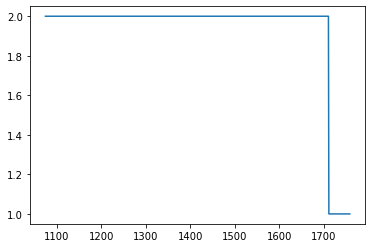

In [6]:
actions = env.features['State'][-df.shape[0]:]
#actions = env.features['State'][:df.shape[0]]
print(actions.describe())
actions.plot()

count    685.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: State, dtype: float64


<AxesSubplot:>

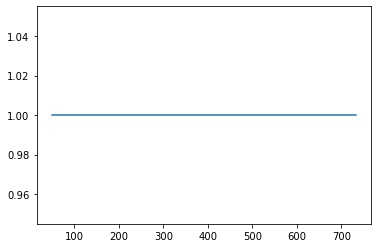

In [7]:
actions = env.features['State'][:df.shape[0]]
#actions = env.features['State'][:df.shape[0]]
print(actions.describe())
actions.plot()